https://www.kaggle.com/code/gerardogutierrey/academic-success-easy-step-by-step-guide-82-acc/notebook

In [6]:
# Import all the necessary tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
#import imblearn

# Now we can import the estimators
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# And the metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
import os
os.chdir('E:\Python code\使用学术成功数据集进行分类数据')

In [8]:
# Now we can import with Pandas the data from the dataset

df = pd.read_csv("train.csv")
df.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


特征工程

In [9]:
# Separate the numerical from the categorical features
float_columns = df.select_dtypes(include='float64').columns.tolist()
int_columns = df.select_dtypes(include='int64').columns.tolist()

float_columns, int_columns

(['Previous qualification (grade)',
  'Admission grade',
  'Curricular units 1st sem (grade)',
  'Curricular units 2nd sem (grade)',
  'Unemployment rate',
  'Inflation rate',
  'GDP'],
 ['id',
  'Marital status',
  'Application mode',
  'Application order',
  'Course',
  'Daytime/evening attendance',
  'Previous qualification',
  'Nacionality',
  "Mother's qualification",
  "Father's qualification",
  "Mother's occupation",
  "Father's occupation",
  'Displaced',
  'Educational special needs',
  'Debtor',
  'Tuition fees up to date',
  'Gender',
  'Scholarship holder',
  'Age at enrollment',
  'International',
  'Curricular units 1st sem (credited)',
  'Curricular units 1st sem (enrolled)',
  'Curricular units 1st sem (evaluations)',
  'Curricular units 1st sem (approved)',
  'Curricular units 1st sem (without evaluations)',
  'Curricular units 2nd sem (credited)',
  'Curricular units 2nd sem (enrolled)',
  'Curricular units 2nd sem (evaluations)',
  'Curricular units 2nd sem (approve

D:\anaconda\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


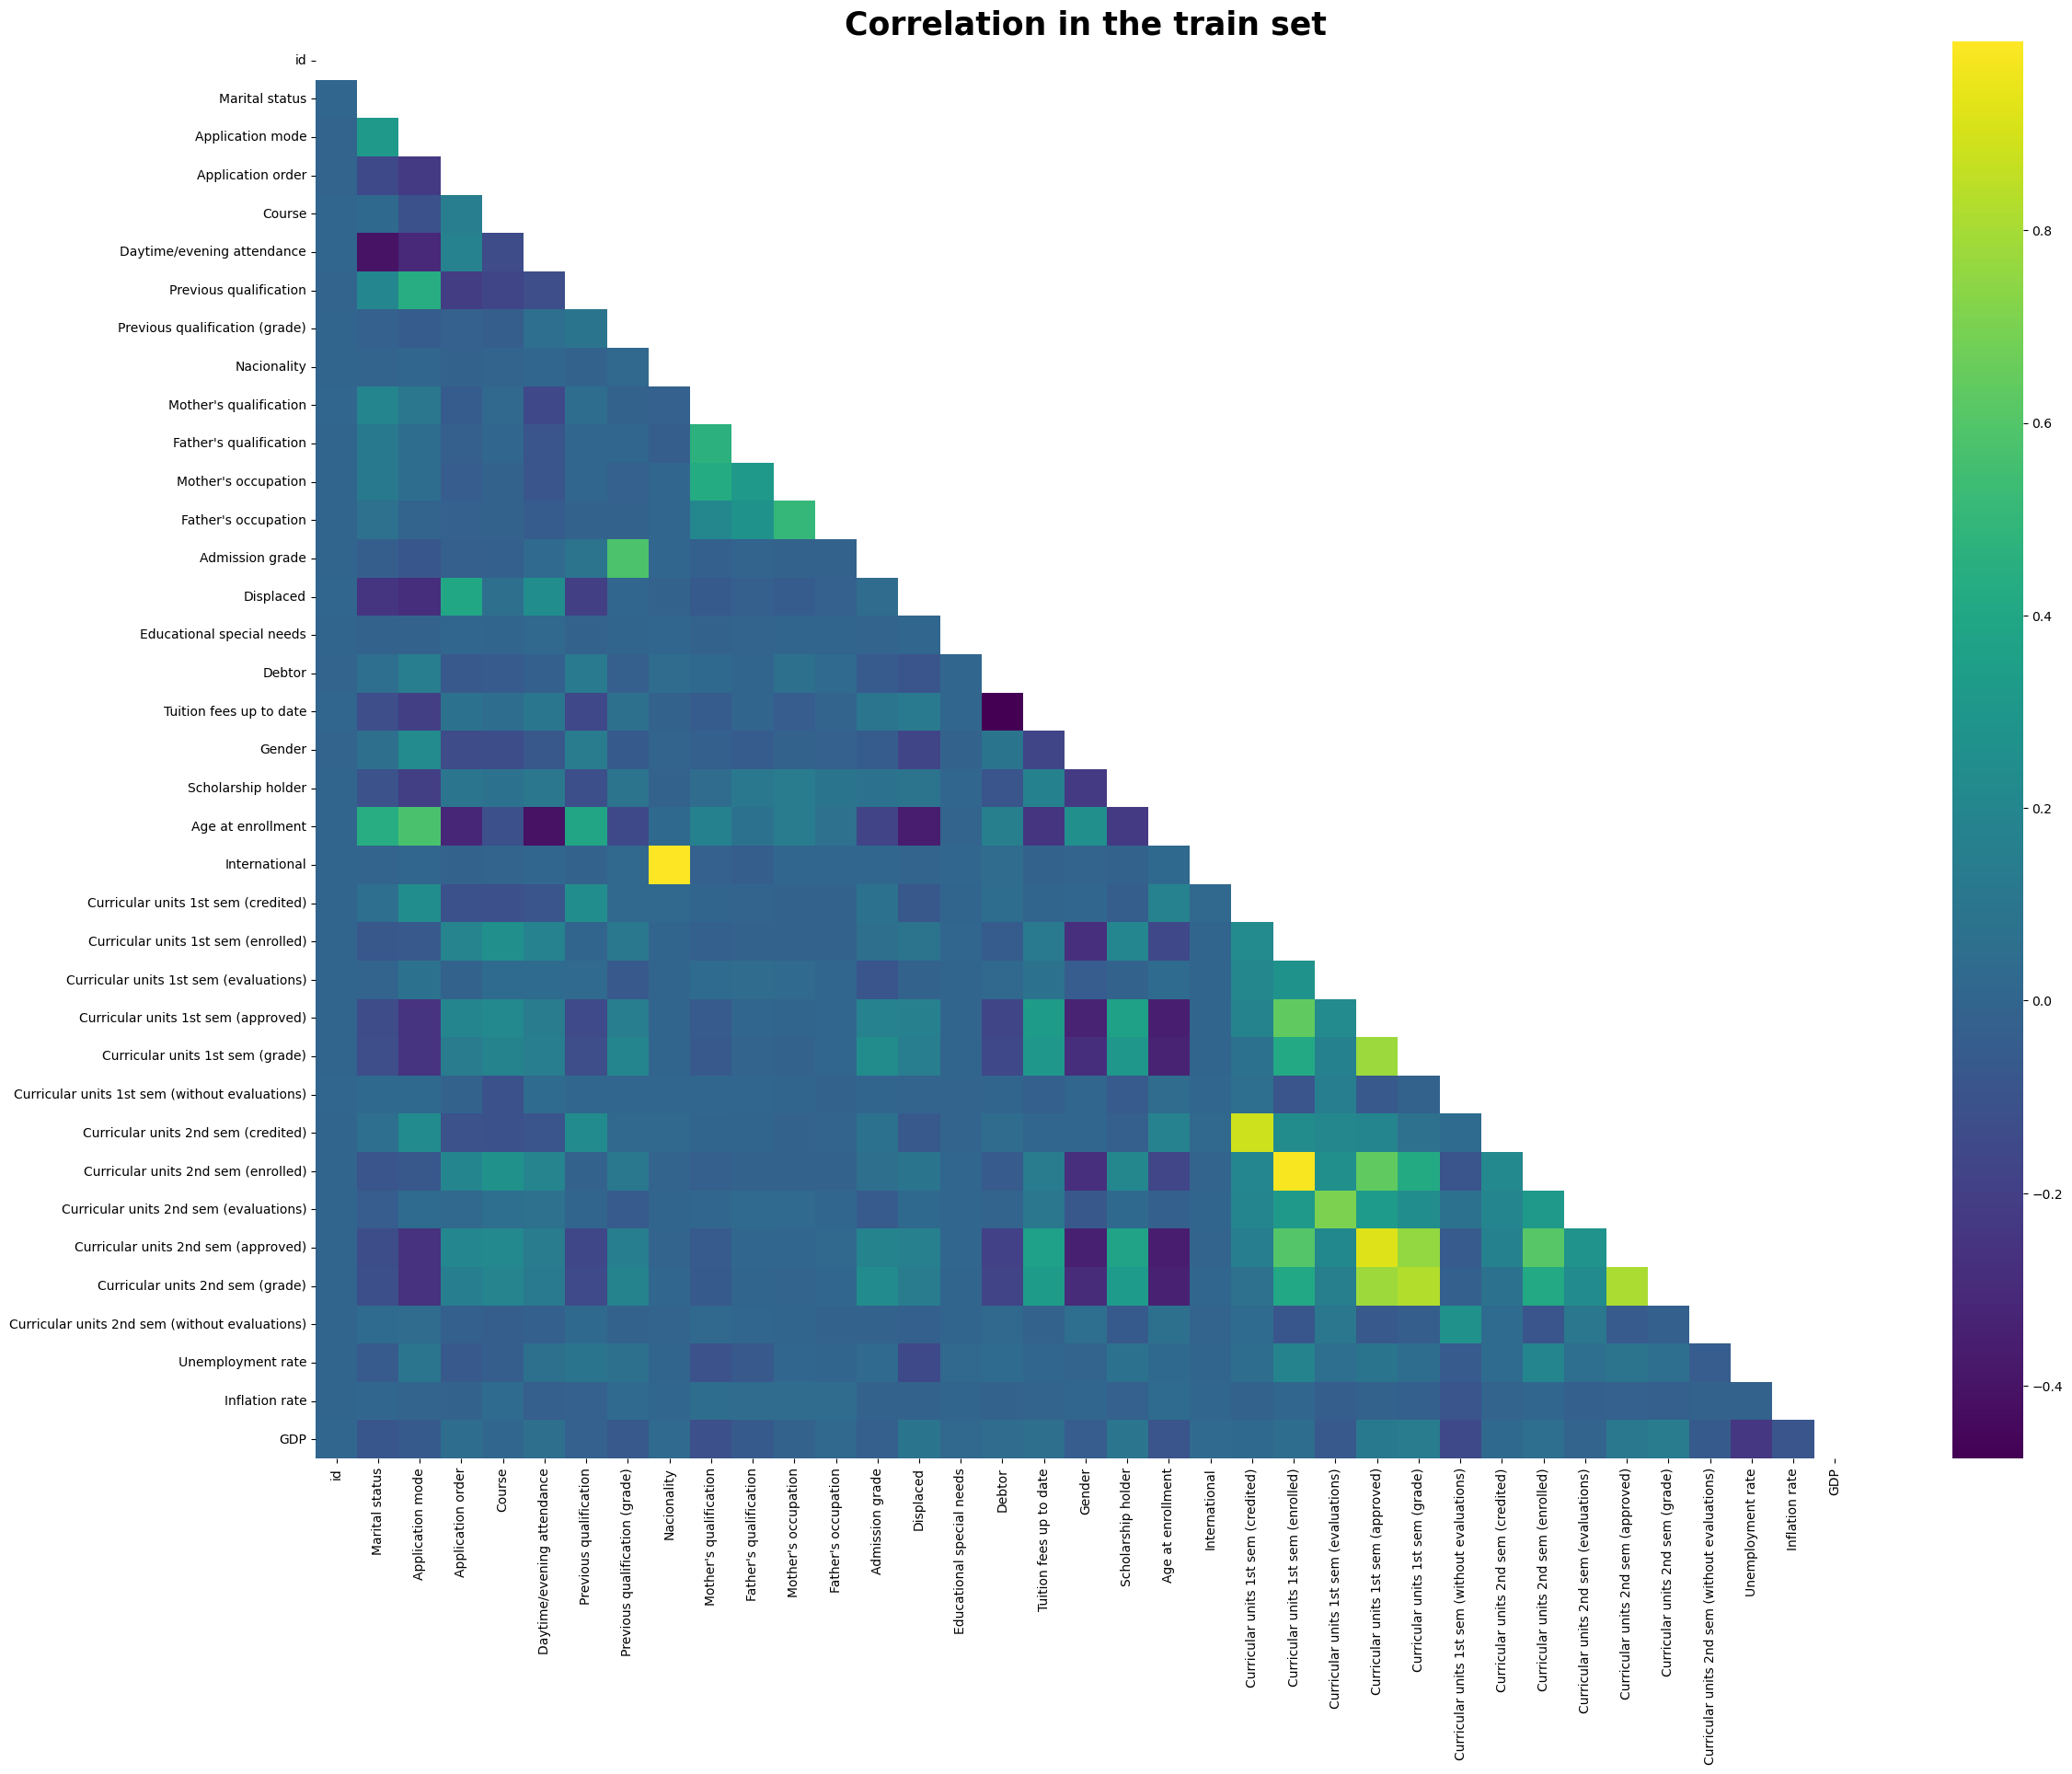

In [10]:
# To check how the features influence each other lets'plot a correlation matrix

# Drop the target column
corr = df.drop("Target", axis=1).corr(method='spearman') # spearman instead of pearson because of the expected non-linear effects

# Cover the up-right side with white cells
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

# Initialize the plot
fig, ax = plt.subplots(figsize=(27,20))
sns.heatmap(data=corr, 
            mask=mask , 
            annot=True,
            cmap='viridis',
            annot_kws={'size': 10, 'rotation': 45}, # set the fontsize to 12 and rotate the text
            ax=ax
            );
ax.set_title(f'Correlation in the train set',fontsize=25, fontweight='bold');

This is a quite interesting correlation matrix. It is possible to observe that some dependencies are obvious, such like the 100% correlation between Nacionality and International or almost the whole down-right area where the enrolled and approved curricular units in the first 2 semesters are. In this case the strategy is to drop all the features with a high correlation, for example higher than 0.9 and to drop also the features with a low variance.

In [11]:
# Let's first find the features with a high correlation

# Calculate the correlation matrix
corr_matrix = df.drop("Target", axis=1).corr(method='spearman').abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop1 = [column for column in upper.columns if any(upper[column] > 0.9)]

print("Highly correlated features to drop:", to_drop1)

Highly correlated features to drop: ['International', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)']


This tells us thatall the information contained in the 2nd sem (enrolled) and 2nd sem (approved) features is actually already contained in the 1st sem features. If we think about it logically it makes sense. The first semester of university is a bottleneck for almost all careers. If someone didn't have a good performance in the first semester, it is very likely that the same will happen and the second semester and the they will dropout the career. So to avoid confusion while modelling we can drop out these features.

Low importance features to drop with an importance lower than 0.5%: ['Marital status', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', 'Educational special needs', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (without evaluations)']


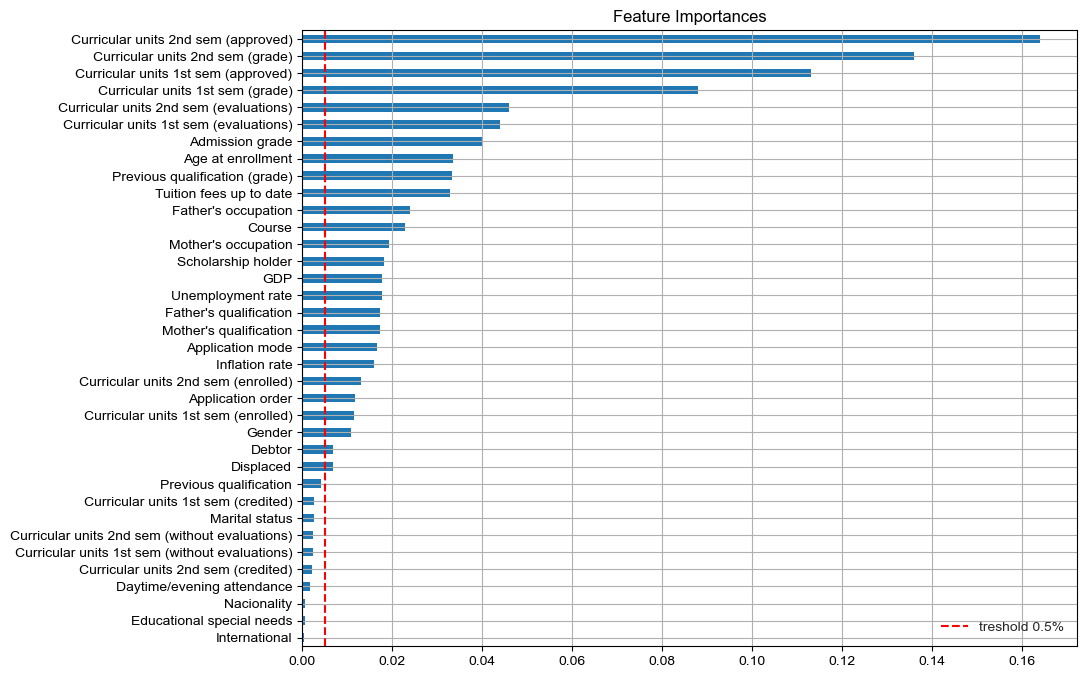

In [12]:
# Create the X and y sets

X = df.drop(["Target", "id"], axis=1)
y = df["Target"]

# Create and fit a RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, y)

# Create a list with the features importances of all collumns
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)
# Get features with importance lower than the treshold
treshold = 0.005
to_drop2 = feature_importances[feature_importances < treshold].index.tolist()

print("Low importance features to drop with an importance lower than 0.5%:", to_drop2)

feature_importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.style.use('seaborn-v0_8-whitegrid')
plt.axvline(x=treshold, color='r', linestyle='--', label=f"treshold {treshold*100}%")
plt.grid(True)
plt.legend()
plt.title('Feature Importances');

The upper graph tells us also which features do not influence into the training of a RandomForestClassifier with no more than 5% (actually a lot of them), which also match the features we wanted to drop because of the correlation matrix. It would be also save to drop them in order to avoid confusion while modelling. Now before we continue it is necessary to look at the target column and look if it has a symmetric distribution.

Target
Graduate    47.416294
Dropout     33.058888
Enrolled    19.524818
Name: count, dtype: float64


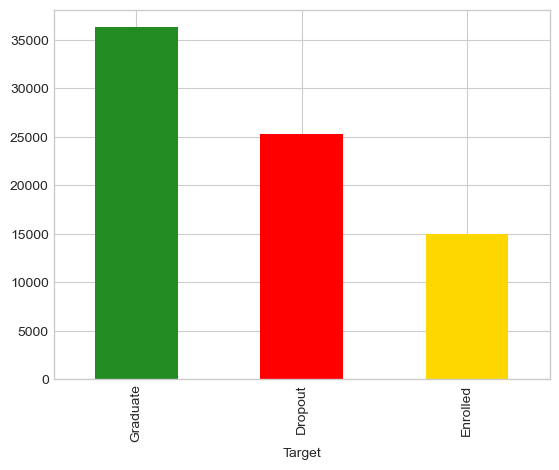

In [8]:
# Print the distributions in percent and then plot them
print(f"{df.Target.value_counts()/df.Target.count()*100}")
df.Target.value_counts().plot(kind="bar", color=["forestgreen", "red", "gold"]);

As we can see, the distribution is moderately asymmetric, that's why it could be convenient to do some preprocess to balance the target distribution. For that we are gonna use the imbalance-learn library which has a very useful feature, which randomly deletes samples from the dominant parameter and also randomly adds entries corresponding to the other parameter. This function is called SMOTETomek.

In [9]:
# Create a temporal DataFrame if we want to restore the whole data
df_tmp = df.copy()

In [10]:
# First we must drop the features that could confuse the model
for item in to_drop2:
    if item not in to_drop1:
        to_drop1.append(item)
to_drop = to_drop1 + ["id"]
print(f"Features to be dropped: {to_drop}")

Features to be dropped: ['International', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)', 'Marital status', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', 'Educational special needs', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (without evaluations)', 'id']


In [11]:
# Drop the features from the temporal DataFrame
df_tmp = df_tmp.drop(to_drop, axis=1)
df_tmp.shape, df.shape

((76518, 25), (76518, 38))

In [12]:
# Let's have a look of the first rows
df_tmp.head()

,Application mode,Application order,Course,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,...,Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (grade),Unemployment rate,Inflation rate,GDP,Target
0,1,1,9238,126.0,1,19,5,5,122.6,0,...,6,6,6,14.500000,7,12.428571,11.1,0.6,2.02,Graduate
1,17,1,9238,125.0,19,19,9,9,119.8,1,...,6,8,4,11.600000,9,0.000000,11.1,0.6,2.02,Dropout
2,17,2,9254,137.0,3,19,2,3,144.7,0,...,6,0,0,0.000000,0,0.000000,16.2,0.3,-0.92,Dropout
3,1,3,9500,131.0,19,3,3,2,126.1,1,...,7,9,7,12.591250,11,12.820000,11.1,0.6,2.02,Enrolled
4,1,2,9500,132.0,19,37,4,9,120.1,1,...,7,12,6,12.933333,12,12.933333,7.6,2.6,0.32,Graduate


We finally have our data preprocessed, what if we model a RandomForestClassifier and show some metrics to see how good is our model even without hyperameter tuning.

In [13]:
# Import the metrics
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek

# Create the X and y sets
X = df_tmp.drop('Target', axis=1)
y = df_tmp['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTETomek to balance the training data
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)

# Train a Random Forest model with class weights
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_res, y_res)

# Predict and evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4018  705  336]
 [ 292 1954  742]
 [ 125  754 6378]]
              precision    recall  f1-score   support

     Dropout       0.91      0.79      0.85      5059
    Enrolled       0.57      0.65      0.61      2988
    Graduate       0.86      0.88      0.87      7257

    accuracy                           0.81     15304
   macro avg       0.78      0.78      0.77     15304
weighted avg       0.82      0.81      0.81     15304



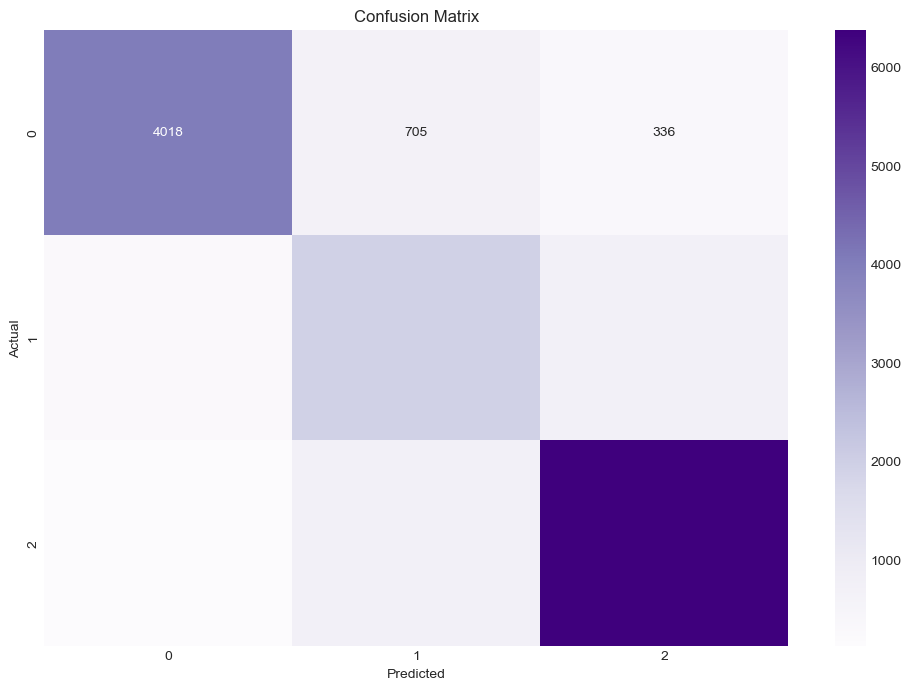

In [14]:
# Create the confusion matrix for the data
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

[[4047  623  389]
 [ 311 1869  808]
 [ 145  676 6436]]
              precision    recall  f1-score   support

     Dropout       0.90      0.80      0.85      5059
    Enrolled       0.59      0.63      0.61      2988
    Graduate       0.84      0.89      0.86      7257

    accuracy                           0.81     15304
   macro avg       0.78      0.77      0.77     15304
weighted avg       0.81      0.81      0.81     15304



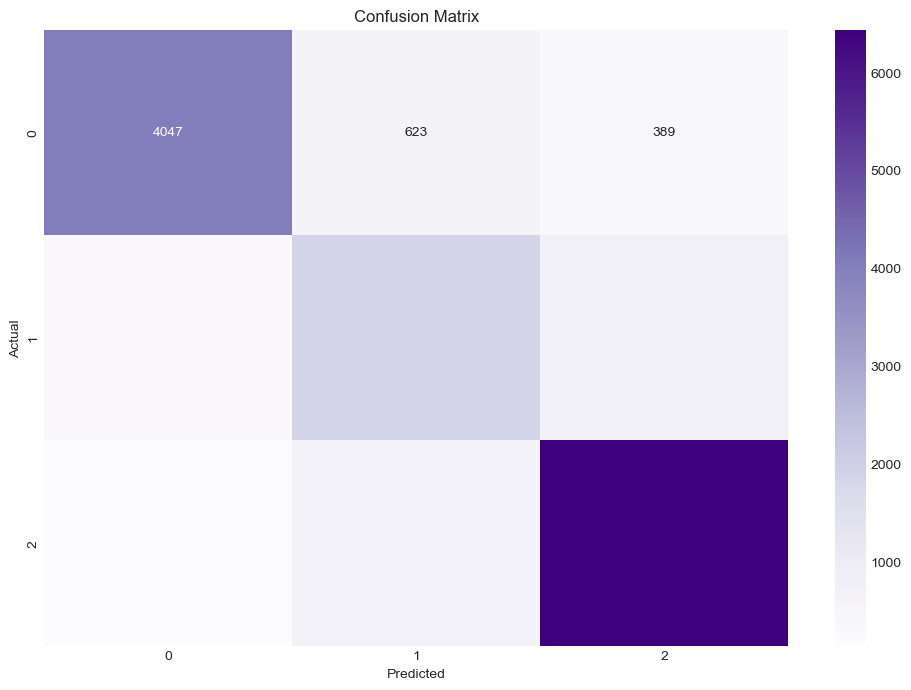

In [15]:
# Train a second Random Forest model with class weights
model2 = RandomForestClassifier(class_weight={'Dropout': 1, 'Enrolled': 3, 'Graduate': 1})
model2.fit(X_res, y_res)

# Predict and evaluate
y_pred2 = model2.predict(X_test)
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

# Create the confusion matrix for the data
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Modelling

Now that we applied feature engineering on the data we can try some machine learning models to observe which can perform better on this data, for that we will use the models imported in the next few cells to ponderate their performance and the decide which of them fits better our requirements.

In [16]:
# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : testing labels
    '''
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    for name, model in models.items():
        # Fit the model to the data
        print(f"Fitting {name}...")
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        print(f"Evaluating {name}...")
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier


In [18]:
# Define models and their respective hyperparameter grids
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'MLP': MLPClassifier(),
    'SVC': SVC(),
    "Logistic Regression" : LogisticRegression(),
    "CatBoost Classifier" : CatBoostClassifier()
}

In [19]:
# In order to use the majority of these models we need to turn the values in the Target column into integers by mapping the y_res and y_test lists
mapping = {'Dropout' : 0,
           'Enrolled' : 1,
           'Graduate' : 2}
y_res, y_test = y_res.map(mapping), y_test.map(mapping)

model_scores = fit_and_score(models, X_res, X_test, y_res, y_test)
model_scores

Fitting RandomForest...
Evaluating RandomForest...
Fitting XGBoost...
Evaluating XGBoost...
Fitting LightGBM...
Evaluating LightGBM...
Fitting MLP...
Evaluating MLP...
Fitting SVC...
Evaluating SVC...
Fitting Logistic Regression...


D:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression...
Fitting CatBoost Classifier...
Learning rate set to 0.099207
0:	learn: 0.9977480	total: 179ms	remaining: 2m 58s
1:	learn: 0.9211417	total: 196ms	remaining: 1m 37s
2:	learn: 0.8596574	total: 213ms	remaining: 1m 10s
3:	learn: 0.8109256	total: 231ms	remaining: 57.6s
4:	learn: 0.7692371	total: 248ms	remaining: 49.4s
5:	learn: 0.7354666	total: 264ms	remaining: 43.8s
6:	learn: 0.7071719	total: 282ms	remaining: 40s
7:	learn: 0.6821459	total: 300ms	remaining: 37.2s
8:	learn: 0.6609749	total: 318ms	remaining: 35s
9:	learn: 0.6412344	total: 338ms	remaining: 33.4s
10:	learn: 0.6249479	total: 355ms	remaining: 31.9s
11:	learn: 0.6104529	total: 373ms	remaining: 30.7s
12:	learn: 0.5977308	total: 390ms	remaining: 29.6s
13:	learn: 0.5863800	total: 407ms	remaining: 28.6s
14:	learn: 0.5768683	total: 424ms	remaining: 27.9s
15:	learn: 0.5682286	total: 442ms	remaining: 27.2s
16:	learn: 0.5604821	total: 458ms	remaining: 26.5s
17:	learn: 0.5530933	total: 476ms	remaining: 26s


{'RandomForest': 0.8090695243073707,
 'XGBoost': 0.8207658128593832,
 'LightGBM': 0.8157344485101934,
 'MLP': 0.6570177731312076,
 'SVC': 0.40244380554103504,
 'Logistic Regression': 0.6881860951385259,
 'CatBoost Classifier': 0.819916361735494}

It is important to emphasize that the time that each model required for training wasn't the same. Actually the SVC algorithm took way longer to train, almost a 100 times more compared to the others.

Note: If we would like to decrease this number, we should simply decrease the training size but risking also a higher standard deviation of the true model's value. In this case because of the lower performance

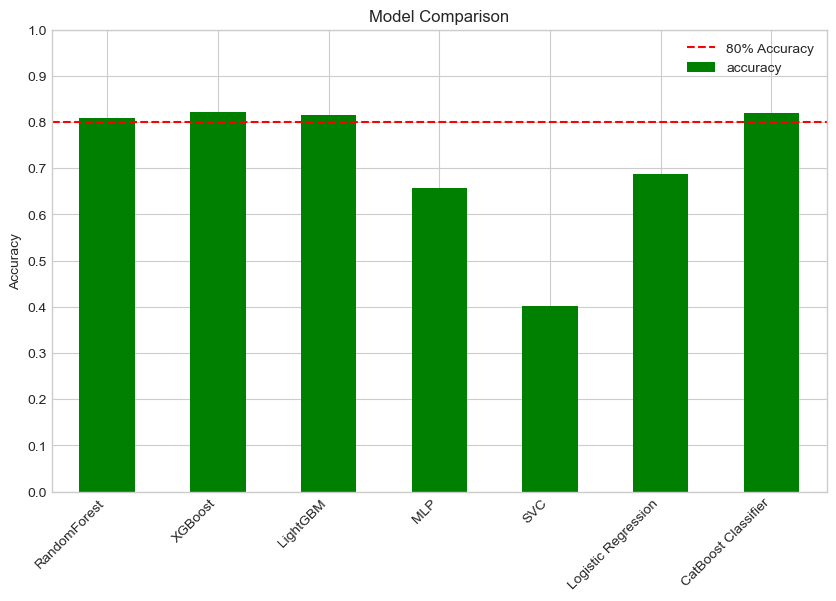

In [20]:
# Turn the dictionary into a DataFrame
model_compare = pd.DataFrame(model_scores, index=["accuracy"])

# Plot the bar chart with conditional colors
ax = model_compare.T.plot(kind='bar', color='green', legend=False, figsize=(10, 6))

# Add labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison')
ax.set_ylim([0,1])
ax.set_yticks(np.arange(0, 1.1, step=0.1))
ax.set_xticklabels(model_compare.columns, rotation=45, ha='right')

# Add a horizontal line for the accuracy limit
ax.axhline(y=0.8, c='r', linestyle='--', label='80% Accuracy')
plt.legend()

# Show the plot
plt.show()

In [21]:
# Select only the models with an accuracy higher than 80%
filtered_models = {model : score for model, score in model_scores.items() if score > 0.80}
filtered_models

{'RandomForest': 0.8090695243073707,
 'XGBoost': 0.8207658128593832,
 'LightGBM': 0.8157344485101934,
 'CatBoost Classifier': 0.819916361735494}

In [22]:
best_models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'MLP': MLPClassifier(),
    "CatBoost Classifier" : CatBoostClassifier()
}
# Create the X and y sets
X = df_tmp.drop('Target', axis=1)
y = df_tmp['Target']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Set random seed
np.random.seed(42)
y_train, y_test = y_train.map(mapping), y_test.map(mapping)
# Make a dictionary to keep model scores
model_scores1 = {}
for name, model in best_models.items():
    # Fit the model to the data
    print(f"Fitting {name}...")
    model.fit(X_train, y_train)
    # Evaluate the model and append its score to model_scores
    print(f"Evaluating {name}...")
    model_scores1[name] = model.score(X_test, y_test)

Fitting RandomForest...
Evaluating RandomForest...
Fitting XGBoost...
Evaluating XGBoost...
Fitting LightGBM...
Evaluating LightGBM...
Fitting MLP...
Evaluating MLP...
Fitting CatBoost Classifier...
Learning rate set to 0.097601
0:	learn: 1.0001038	total: 16.1ms	remaining: 16s
1:	learn: 0.9224932	total: 31ms	remaining: 15.5s
2:	learn: 0.8622153	total: 45.5ms	remaining: 15.1s
3:	learn: 0.8136269	total: 59.8ms	remaining: 14.9s
4:	learn: 0.7730556	total: 74.2ms	remaining: 14.8s
5:	learn: 0.7377609	total: 89.3ms	remaining: 14.8s
6:	learn: 0.7092062	total: 104ms	remaining: 14.7s
7:	learn: 0.6837673	total: 118ms	remaining: 14.6s
8:	learn: 0.6619849	total: 134ms	remaining: 14.7s
9:	learn: 0.6427503	total: 148ms	remaining: 14.7s
10:	learn: 0.6262234	total: 161ms	remaining: 14.5s
11:	learn: 0.6123155	total: 176ms	remaining: 14.5s
12:	learn: 0.5995052	total: 188ms	remaining: 14.3s
13:	learn: 0.5881238	total: 202ms	remaining: 14.2s
14:	learn: 0.5780723	total: 217ms	remaining: 14.2s
15:	learn: 0.5

This is part of experimenting and trying to improve the trained models, sometimes doing nothing is better than changing something. The change is not very high but it is clear that all models improved almost 1% without the target balancing techniques. Thus we will continue the training without resample techniques.

# Hyperparameter tuning

Now that we compared the performance of all models, it could be worth it to check if we can improve the accuracy of the best models further by applying hyperparameter tuning. For this firstly we will try some random tuning using RandomizedSearchCV() to compare the results with the default settings of the models and make further decisions about which parameters will be later tuned using GridSearchCV()

In [23]:
# Import the RandomizedSearchCV function
from sklearn.model_selection import RandomizedSearchCV
#超参数
# Define parameter grids for each model
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'colsample_bytree': [0.3, 0.7, 1]
    },
    'LGBMClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 61, 91],
        'boosting_type': ['gbdt', 'dart']
    },
    'CatBoostClassifier': {
        'iterations': np.linspace(100, 1000, 10, dtype=int),
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'border_count': [32, 50, 100, 150, 200],
        'bagging_temperature': [0.1, 0.2, 0.5, 0.8, 1],
        'random_strength': [1, 2, 5, 10],
        'leaf_estimation_iterations': [1, 5, 10]
    }
}

# Create the X and y sets
X = df_tmp.drop('Target', axis=1)
y = df_tmp['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_train, y_test = y_train.map(mapping), y_test.map(mapping)

# Store the results
best_models = {}
best_scores = {}


# Iterate over the models and their parameter grids
for model_name, params in param_grids.items():
    if model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(random_state=42)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(random_state=42)
    elif model_name == 'LGBMClassifier':
        model = LGBMClassifier(random_state=42)
    elif model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(silent=True, random_state=42)

    # Setup the randomized search
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, 
                                       n_iter=25, scoring='accuracy', cv=5, verbose=1, n_jobs=-1, random_state=42)
    
    # Fit the randomized search
    random_search.fit(X_train, y_train)
    
    # Store the best parameters and best score
    best_models[model_name] = random_search.best_params_
    best_scores[model_name] = random_search.best_score_

# Print the best parameters and scores
for model_name in best_models.keys():
    print(f"Best parameters for {model_name}: {best_models[model_name]}")
    print(f"Best score for {model_name}: {best_scores[model_name]}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters for RandomForestClassifier: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Best score for RandomForestClassifier: 0.8138824898298163
Best parameters for XGBClassifier: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.3}
Best score for XGBClassifier: 0.8206783232580597
Best parameters for LGBMClassifier: {'num_leaves': 31, 'n_estimators': 200, 'learning_rate': 0.2, 'boosting_type': 'dart'}
Best score for LGBMClassifier: 0.8187833508628298
Best parameters for CatBoostClassifier: {'random_strength': 2, 'learning_rate': 0.1, 'leaf_estimation_iterations': 1, 'l2_leaf_reg': 5, 'iterations': 400, 'depth': 6, 'border_count': 200, 'bagging_temperature': 0.2}
Best

In [24]:
# And also of the parameters
best_models

{'RandomForestClassifier': {'n_estimators': 200,
  'min_samples_split': 5,
  'min_samples_leaf': 4,
  'max_depth': None},
 'XGBClassifier': {'n_estimators': 200,
  'max_depth': 6,
  'learning_rate': 0.2,
  'colsample_bytree': 0.3},
 'LGBMClassifier': {'num_leaves': 31,
  'n_estimators': 200,
  'learning_rate': 0.2,
  'boosting_type': 'dart'},
 'CatBoostClassifier': {'random_strength': 2,
  'learning_rate': 0.1,
  'leaf_estimation_iterations': 1,
  'l2_leaf_reg': 5,
  'iterations': 400,
  'depth': 6,
  'border_count': 200,
  'bagging_temperature': 0.2}}

In [25]:
# Calculate the performance difference before and after RandomSearchCV
difference = [a - b for a, b in zip(best_scores.values(), filtered_models.values())]
difference

[0.004812965522445589,
 -8.748960132354267e-05,
 0.00304890235263644,
 -0.0002835298593178992]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18052\702719245.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(best_scores.keys(), rotation=45, ha='right');


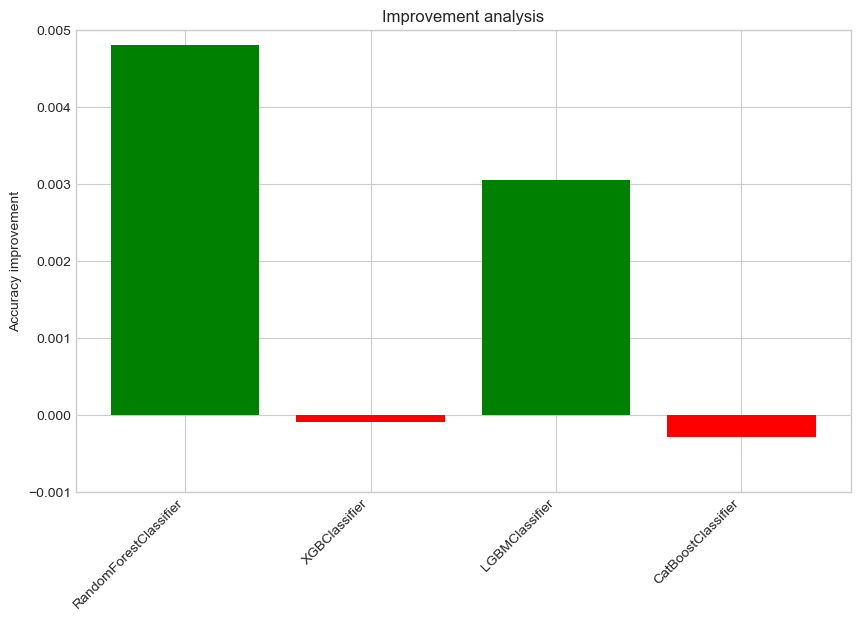

In [26]:
colors = ['green' if score > 0 else 'red' for score in difference]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(best_scores.keys(), difference, color=colors)

# Add labels and title
ax.set_ylabel('Accuracy improvement')
ax.set_title('Improvement analysis')
ax.set_ylim([-0.001, 0.005])
ax.set_xticklabels(best_scores.keys(), rotation=45, ha='right');

We can observe that both the RandomForestClassifier and the LGBMClassifier had a considerable improvement of almost 5%, while the other two models performed a bit worse than before the hyperparameter tuning. For this reason we will consider all four models for hyperparameter tuning using GridSearchCV() hoping their performance to improve. We will take the approach in which we assume the hyperparameters of these models are already approaching a maximum in performance, so the parameters found by using RandomSearchCV() will only be changed a bit.

In [27]:
best_models

{'RandomForestClassifier': {'n_estimators': 200,
  'min_samples_split': 5,
  'min_samples_leaf': 4,
  'max_depth': None},
 'XGBClassifier': {'n_estimators': 200,
  'max_depth': 6,
  'learning_rate': 0.2,
  'colsample_bytree': 0.3},
 'LGBMClassifier': {'num_leaves': 31,
  'n_estimators': 200,
  'learning_rate': 0.2,
  'boosting_type': 'dart'},
 'CatBoostClassifier': {'random_strength': 2,
  'learning_rate': 0.1,
  'leaf_estimation_iterations': 1,
  'l2_leaf_reg': 5,
  'iterations': 400,
  'depth': 6,
  'border_count': 200,
  'bagging_temperature': 0.2}}

In [18]:






# Create a temporal DataFrame if we want to restore the whole data
df_tmp = df.copy()
# Calculate the correlation matrix
corr_matrix = df.drop("Target", axis=1).corr(method='spearman').abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop1 = [column for column in upper.columns if any(upper[column] > 0.9)]

# Find features with correlation greater than 0.95
to_drop1 = [column for column in upper.columns if any(upper[column] > 0.9)]

# First we must drop the features that could confuse the model
for item in to_drop2:
    if item not in to_drop1:
        to_drop1.append(item)
to_drop = to_drop1 + ["id"]
print(f"Features to be dropped: {to_drop}")

# Drop the features from the temporal DataFrame
df_tmp = df_tmp.drop(to_drop, axis=1)
df_tmp.shape, df.shape

X = df_tmp.drop('Target', axis=1)
y = df_tmp['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

mapping = {'Dropout' : 0,
           'Enrolled' : 1,
           'Graduate' : 2}

y_train, y_test = y_train.map(mapping), y_test.map(mapping)


Features to be dropped: ['International', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)', 'Marital status', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality', 'Educational special needs', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (without evaluations)', 'id']


In [ ]:
# Import the RandomizedSearchCV function
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grids_GS = {
    'RandomForestClassifier': {
        'n_estimators': [190, 200, 210],
        'max_depth': [None],
        'min_samples_split': [4, 5, 6],
        'min_samples_leaf': [3, 4, 5]
    },
    'XGBClassifier': {
        'n_estimators': [190, 200, 210],
        'learning_rate': [0.2, 0.5],
        'max_depth': [5, 6, 7],
        'colsample_bytree': [0.2, 0.3, 0.4]
    },
    'LGBMClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [21, 31, 41],
        'boosting_type': ['dart']
    },
    'CatBoostClassifier': {
        'iterations': np.linspace(300, 500, 3, dtype=int),
        'learning_rate': [0.1, 0.3],
        'depth': [5, 6, 7],
        'l2_leaf_reg': [4, 5, 6],
        'bagging_temperature': [0.2, 0.3],
        'random_strength': [2, 3]
    }
}

# Store the results
best_models_GS = {}
best_scores_GS = {}


# Iterate over the models and their parameter grids
for model_name, params in param_grids_GS.items():
    if model_name == 'RandomForestClassifier':
        print('RandomForestClassifier')
        model = RandomForestClassifier(random_state=42)
    elif model_name == 'XGBClassifier':
        print('XGBClassifier')
        model = XGBClassifier(random_state=42)
    elif model_name == 'LGBMClassifier':
        print('LGBMClassifier')
        model = LGBMClassifier(random_state=42)
    elif model_name == 'CatBoostClassifier':
        print('CatBoostClassifier')
        model = CatBoostClassifier(silent=True, random_state=42)

    # Setup the randomized search
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
    
    # Fit the randomized search
    grid_search.fit(X_train, y_train)
    
    # Store the best parameters and best score
    best_models_GS[model_name] = grid_search.best_params_
    best_scores_GS[model_name] = grid_search.best_score_

# Print the best parameters and scores
for model_name in best_models_GS.keys():
    print(f"Best parameters for {model_name}: {best_models_GS[model_name]}")
    print(f"Best score for {model_name}: {best_scores_GS[model_name]}")

RandomForestClassifier
Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [ ]:
# Let's look now at the improvement achieved compared to the random tuning
difference_search = [a - b for a, b in zip(best_scores_GS.values(), best_scores.values())]
difference_search

In [ ]:
# Visualize
colors = ['green' if score > 0 else 'red' for score in difference_search]
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(best_scores.keys(), difference_search, color=colors)

# Add labels and title
ax.set_ylabel('Accuracy improvement')
ax.set_title('Improvement analysis')
ax.set_ylim([-0.001, 0.005])
ax.set_xticklabels(best_scores.keys(), rotation=45, ha='right');

Specially XGBClassifier showed an increase in its performance by reaching an accuracy of almost 82.2%

Conclusion: The best hyperparameters found using GridSearchCV() for XGBClassifier will be used to train the definitive model we'll be using to submit our predictions for this Kaggle competition.

In [ ]:
# Create X & y sets
X = df_tmp.drop('Target', axis=1)
y = df_tmp['Target']

# Map the y set
y = y.map(mapping)

# Apply SMOTETomek to balance the training data
smote_tomek = SMOTETomek(random_state=42)
X, y = smote_tomek.fit_resample(X, y)

# Train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Create the model
model = XGBClassifier(colsample_bytree=0.2,
                      learning_rate=0.2,
                      max_depth=5,
                      n_estimators=200)

# Fit the data
model.fit(X_train, y_train)

# Score the data
model.score(X_test, y_test)

In [ ]:
# Load the test data
df_test = pd.read_csv("test.csv")
df_test.head()

In [ ]:
# Preprocess the data to match it with the 
df_test = df_test.drop(to_drop, axis=1)

In [ ]:
# Great! Now we can predict the values from the test set
y_preds = model.predict(df_test)

In [ ]:
# Now we have to remap again to have strings instead of integers
mapping_inv = {0 : 'Dropout',
               1 : 'Enrolled',
               2 : 'Graduate'}

# Transform the numpy array into a pandas Series
y_preds = pd.Series(y_preds)

# Map the values
y_preds = y_preds.map(mapping_inv)

# Check if it worked
y_preds

In [ ]:
# Load the dataframe again, because while preprocessing we deleted the id column
df_test = pd.read_csv("data/test.csv")

# Create the id column
student_id = df_test['id']
student_id

In [ ]:
# Create the sample submission
data = {'id' : student_id,
        'Target' : y_preds} 

submission = pd.DataFrame(data)
submission.head()

In [ ]:
# Save the DataFrame as a csv file
submission.to_csv("submission.csv", index=False)

# Neural Network Training¶

The data offered for this problem is actually quite big, with more than 70k entries, that's why it could be a good idea to try a deep learning model to let the neural network to find itself patterns in the data and create a more robust model, where bot feature engineering and training are condensed into one step. For that we will use the TensorFlow library. In the next cell we give the problem a first try to see if it is worth it to keep trying further wit hyperparameter tuning.

Note: For a Neural Network Training in most part of the cases a GPU would be needed reduce computation time. For that Google Colab lets us use a powerful GPU from the Google Servers only for a reduced period of time, which should be enough for not very complicated models. A better and deeper explanation of how to use GPU for tensorflow in colab can be found here: https://colab.research.google.com/notebooks/gpu.ipynb

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop
from sklearn.preprocessing import StandardScaler

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Build the model
model = tf.keras.Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001, momentum=0.8), 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
# Learning scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))
lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_data=(X_test_scaled, y_test), 
                    callbacks=[early_stopping, reduce_lr, lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()